# NLP processes

This notebook's purpose is to perform different NLP algorithms to the `review_text_translated` feature and decide which transformation is the one that provides the most information for the ML model training in the next phase. 

In [1]:
# Imports
import boto3
import pandas as pd
from textblob import TextBlob
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
from wordcloud import WordCloud

from sklearn.decomposition import TruncatedSVD
from IPython.display import Image, display, HTML
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from textstat import textstat

from gensim import corpora
from gensim.models.ldamodel import LdaModel
from nltk.stem import WordNetLemmatizer

In [2]:
df = pd.read_parquet("../output/l3_data_2024-09-03_16-49-31.parquet", engine="pyarrow")

# # Set up boto3 client (this step is optional and not necessary for using s3fs directly)
# s3_client = boto3.client('s3', region_name='us-west-2')

# # Define bucket and object key
# bucket_name = 'andorra-hotels-data-warehouse'
# object_key = 'l3_data/text/lsth.parquet'

# # Construct the S3 file path
# s3_file_path = f's3://{bucket_name}/{object_key}'

# Load the Parquet file into a pandas DataFrame
# s3_file_path = "../output/l3_data_2024-09-01_10-02-26.parquet"
# df = pd.read_parquet(s3_file_path, engine='pyarrow')

# Display the first few rows of the DataFrame
# df_head = data.head()
# df_head.style.hide()
df

,avg_rating,user_ratings_total,review_rating,review_date_in_days,review_text_translated,review_length,distance_to_ski_resort,distance_to_city_center,hotel_id,region_Andorra la Vella,...,region_Encamp,region_Escaldes-Engordany,region_La Massana,region_Ordino,region_Sant Julià de Lòria,lang_ca,lang_en,lang_es,lang_fr,lang_other
0,4.4,581,5.0,730,the outdoor bar with seating that faced the va...,336,6.893862,9.107310,26,False,...,False,False,False,True,False,False,True,False,False,False
1,3.9,1194,3.0,60,We stayed one night at this structure that was...,216,4.926610,1.180006,131,False,...,True,False,False,False,False,False,False,False,False,True
2,4.2,1081,4.0,150,Good location two minutes walk from the main s...,861,5.741960,1.934028,116,False,...,True,False,False,False,False,False,False,True,False,False
3,3.8,601,4.0,730,It is located in a quiet area perhaps someAbou...,126,6.124637,2.522790,65,False,...,False,False,False,True,False,False,False,True,False,False
4,4.3,1257,4.0,150,stayed just 1night hotel was clean staff frien...,128,5.588254,1.346464,79,False,...,False,True,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30753,4.3,1257,3.0,1460,hotel was ok but had badly broken sleep as we ...,173,5.588254,1.346464,79,False,...,False,False,False,False,True,False,True,False,False,False
30754,4.1,136,5.0,1460,nice apartments in the mountains,32,9.017746,12.642774,140,False,...,False,False,False,False,False,False,True,False,False,False
30755,4.4,655,5.0,150,Just at the LDO of the telecabine of the Palar...,233,0.938402,4.448480,145,False,...,False,False,True,False,False,False,False,True,False,False
30756,4.2,1797,3.0,90,No parking we have this park 1 km aquatic corn...,724,5.601433,1.583385,52,True,...,False,False,False,False,False,False,False,False,True,False


In [3]:
# Preprocess Text
# We remove punctuation and lowercase all text
df['cleaned_review'] = df['review_text_translated'].str.lower().str.replace('[^\w\s]', '')

## 1. **TF-IDF (Term Frequency-Inverse Document Frequency):**
   - **Why:** TF-IDF is a well-established method that helps identify the importance of words in a document relative to the entire dataset. It balances the frequency of words with their distinctiveness across the dataset, which is crucial when dealing with a large number of reviews.
   - **How:** Convert your text data into a TF-IDF matrix, where each review is represented as a vector. This technique can help you capture the importance of specific words that might correlate strongly with ratings (e.g., "excellent" might correlate with higher ratings).

Compute TF-IDF

In [4]:
# Compute TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')  # Limit to top 1000 features for better performance
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_review'])

# Convert to DataFrame for easy analysis
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Print the shape of the TF-IDF matrix
print(f"TF-IDF matrix shape: {tfidf_df.shape}")

TF-IDF matrix shape: (30758, 1000)


Visualize Important Words Using a Word Cloud

To understand which words are the most important in the dataset, we can generate a WordCloud using the TF-IDF values.

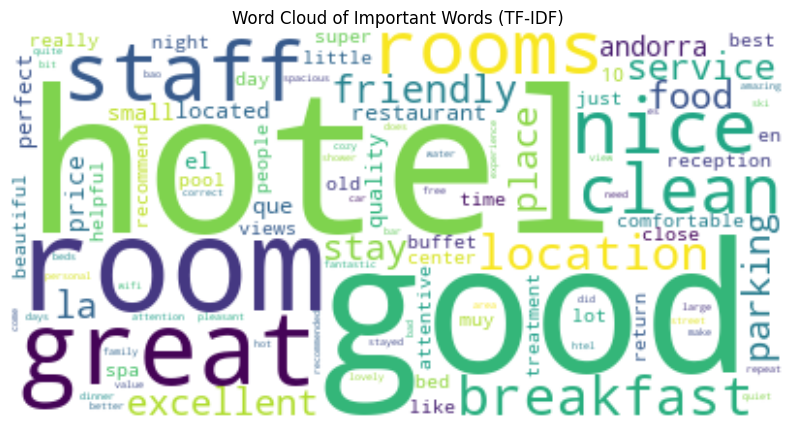

In [5]:
# Generate Word Cloud
wordcloud = WordCloud(background_color="white", max_words=100).generate_from_frequencies(
    dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_matrix.sum(axis=0).A1))
)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Important Words (TF-IDF)")
plt.show()

Dimensionality Reduction Using Truncated SVD (for Visualization)

Since TF-IDF can result in a high-dimensional space, we can reduce the dimensionality of the matrix using Truncated SVD to plot it and understand how well it captures variance.

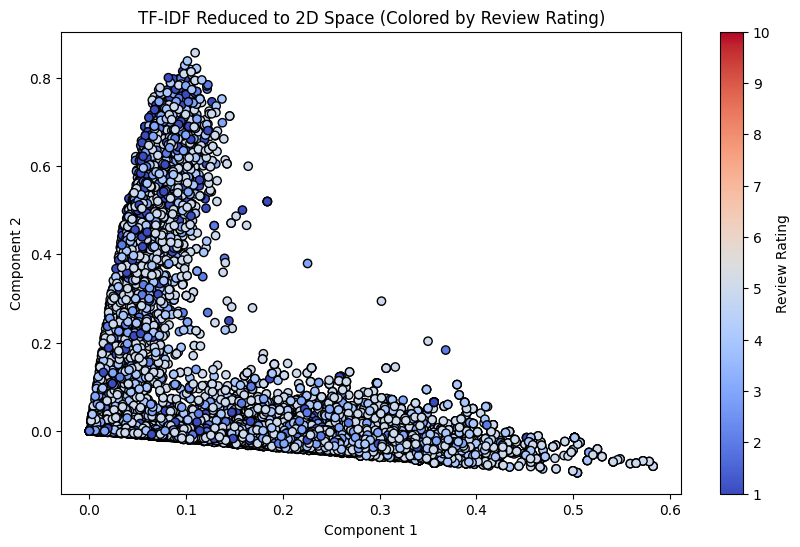

Explained variance ratio by the 2 components: 0.033332892779631015


In [6]:
# Perform dimensionality reduction for visualization
svd = TruncatedSVD(n_components=2)  # Reduce to 2 components for plotting
tfidf_reduced = svd.fit_transform(tfidf_matrix)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(tfidf_reduced[:, 0], tfidf_reduced[:, 1], c=df['review_rating'], cmap='coolwarm', edgecolor='k')
plt.colorbar(label='Review Rating')
plt.title("TF-IDF Reduced to 2D Space (Colored by Review Rating)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

# Print explained variance
print(f"Explained variance ratio by the 2 components: {svd.explained_variance_ratio_.sum()}")

Correlation Analysis with Review Ratings

To understand if the TF-IDF features are useful, we can correlate the top TF-IDF features with the review_rating to check if certain words appear more frequently in positive or negative reviews.

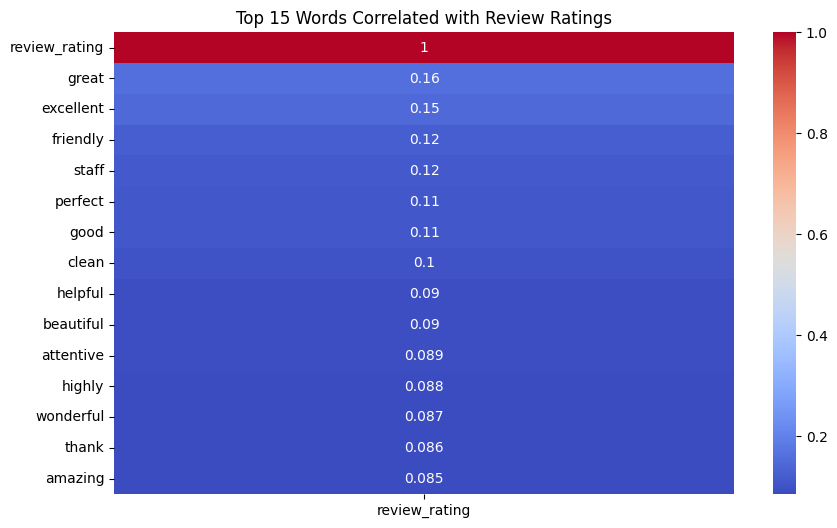

In [7]:
# Correlate top words with review ratings
tfidf_df['review_rating'] = df['review_rating']  # Add the review ratings back to the TF-IDF DataFrame

# Compute correlations
correlation_matrix = tfidf_df.corr()

# Plot the top correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix[['review_rating']].sort_values(by='review_rating', ascending=False).head(15), annot=True, cmap='coolwarm')
plt.title('Top 15 Words Correlated with Review Ratings')
plt.show()

## 2. **Word Embeddings (e.g., Word2Vec, GloVe):**
   - **Why:** Word embeddings capture the semantic meaning of words in a continuous vector space, where words with similar meanings are close to each other. This is particularly useful for capturing nuances in review text.
   - **How:** You can use pre-trained embeddings or train your own on the review dataset. Each review can be represented by averaging the word vectors (mean embedding) or using more sophisticated approaches like weighted averaging based on TF-IDF scores.

Preprocessing the Text Data:
Before applying any word embedding technique, we need to preprocess the review texts by tokenizing, lowercasing, removing stopwords, and handling punctuation.

In [8]:
# Ensure stopwords are downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Define stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    return tokens

# Apply preprocessing to the review_text_translated column
df['cleaned_review_text'] = df['review_text_translated'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/normagutierrez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/normagutierrez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Generate Word Embeddings

We’ll use Gensim’s Word2Vec to train word embeddings on the review dataset. Afterward, we’ll create a mean embedding for each review by averaging the word vectors.

In [9]:
# Train Word2Vec model
sentences = df['cleaned_review_text'].tolist()
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

# Function to get the average word vector for a review
def get_mean_embedding(review_tokens, model):
    valid_words = [word for word in review_tokens if word in model.wv.index_to_key]
    if valid_words:
        return sum(model.wv[word] for word in valid_words) / len(valid_words)
    else:
        return np.zeros(model.vector_size)

# Apply the function to get mean embeddings for each review
df['mean_embedding'] = df['cleaned_review_text'].apply(lambda x: get_mean_embedding(x, w2v_model))

Dimensionality Reduction for Visualization (PCA/t-SNE)

Now, we’ll use PCA to reduce the dimensionality of the embeddings to 2D for visualization.

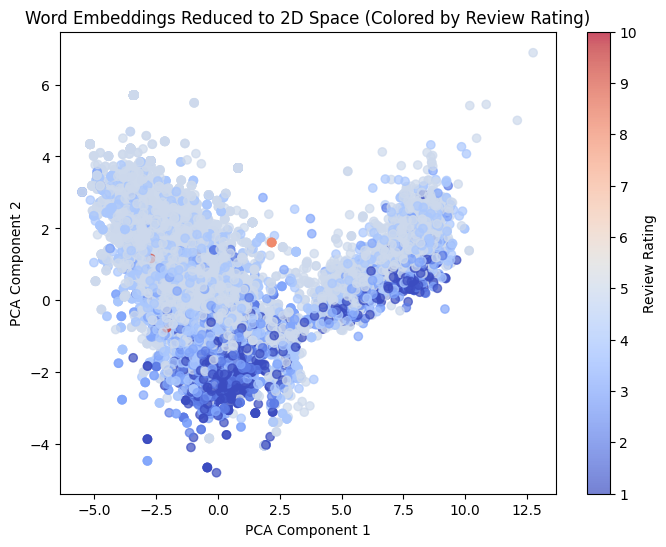

In [10]:
# Extract the mean embeddings
mean_embeddings = np.array(df['mean_embedding'].tolist())

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(mean_embeddings)

# Add the PCA results to the dataframe
df['pca_1'] = pca_result[:, 0]
df['pca_2'] = pca_result[:, 1]

# Plot the PCA results, color by review_rating
plt.figure(figsize=(8, 6))
plt.scatter(df['pca_1'], df['pca_2'], c=df['review_rating'], cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Review Rating')
plt.title('Word Embeddings Reduced to 2D Space (Colored by Review Rating)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

Word Cloud of Important Words Using Embeddings

We will identify words that are close to the center of high-rating embeddings and generate a word cloud based on their frequency and importance.

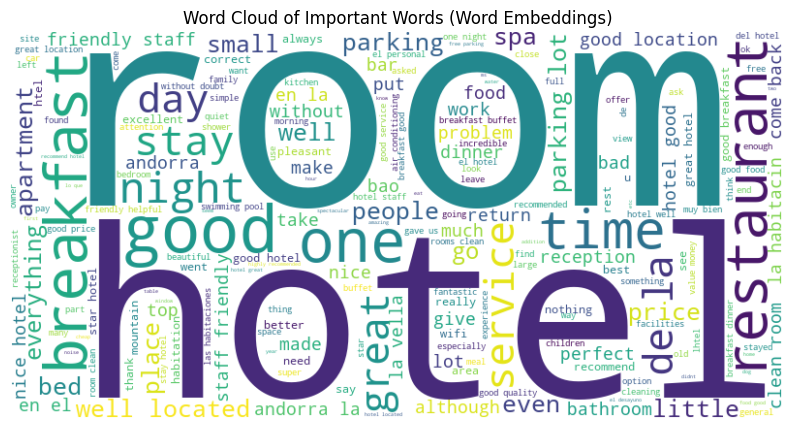

In [11]:
# Generate a WordCloud using the most frequent words from the reviews
all_words = ' '.join([' '.join(tokens) for tokens in df['cleaned_review_text']])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Plot the Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Important Words (Word Embeddings)')
plt.show()

Correlation Analysis of Embedding Features

Here, we’ll calculate the correlation between the review ratings and the most prominent dimensions in the word embeddings.

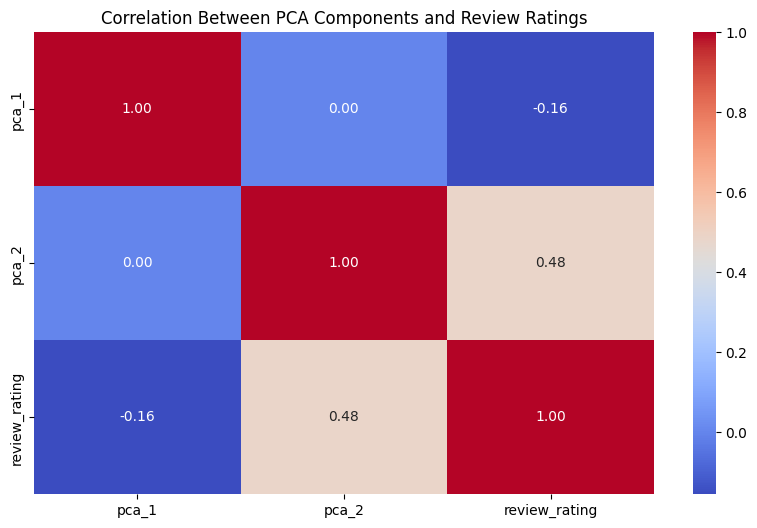

In [12]:
# Correlation between the first two PCA components and review ratings
embedding_df = pd.DataFrame(pca_result, columns=['pca_1', 'pca_2'])
embedding_df['review_rating'] = df['review_rating']

# Calculate correlation
correlation_matrix = embedding_df.corr()

# Plot the heatmap of correlations
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between PCA Components and Review Ratings')
plt.show()

## 3. **N-grams (Bi-grams, Tri-grams):**
   - **Why:** While individual words are informative, certain combinations of words (like "not good," "highly recommend") carry significant meaning. N-grams can help capture these phrases.
   - **How:** Extend your TF-IDF or BoW models to include bi-grams or tri-grams. This can be especially useful if your reviews contain many such meaningful phrases.

In [13]:
# Load the review text
reviews = df['review_text_translated']

# Generate Bi-grams using TF-IDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2, 2), stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(reviews)

# Get the feature names (bi-grams) and their corresponding TF-IDF scores
bi_gram_features = tfidf_vectorizer.get_feature_names_out()

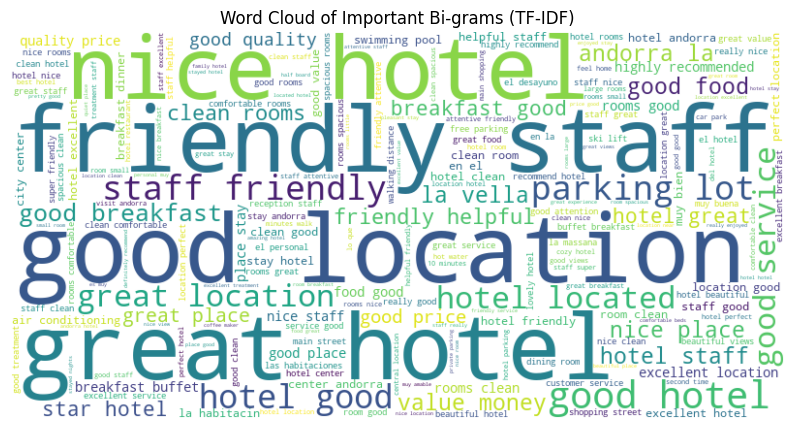

In [14]:
# Create a Word Cloud of Bi-grams
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(
    dict(zip(bi_gram_features, np.ravel(tfidf_matrix.sum(axis=0))))
)

# Plot Word Cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Important Bi-grams (TF-IDF)")
plt.show()

In [15]:
# Step 3: Perform Truncated SVD for dimensionality reduction (works on sparse matrices)
svd = TruncatedSVD(n_components=2)
reduced_tfidf = svd.fit_transform(tfidf_matrix)


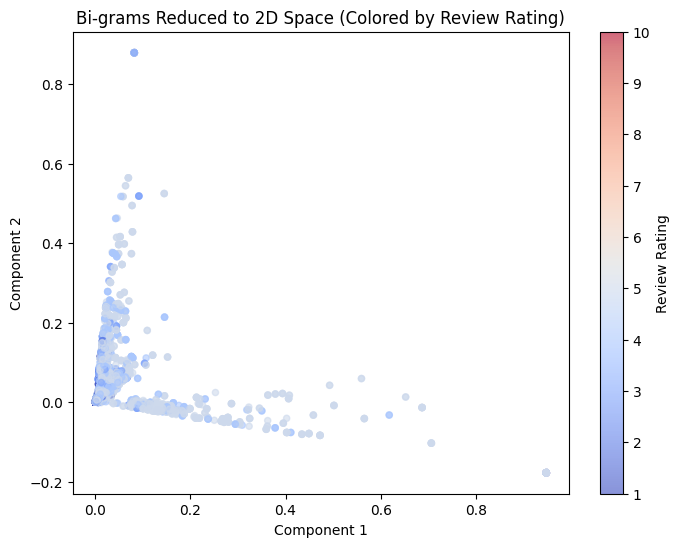

In [16]:
# Step 4: Create a scatter plot for PCA-reduced features
ratings = df['review_rating']

plt.figure(figsize=(8, 6))
plt.scatter(reduced_tfidf[:, 0], reduced_tfidf[:, 1], c=ratings, cmap='coolwarm', s=20, alpha=0.6)
plt.colorbar(label='Review Rating')
plt.title('Bi-grams Reduced to 2D Space (Colored by Review Rating)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

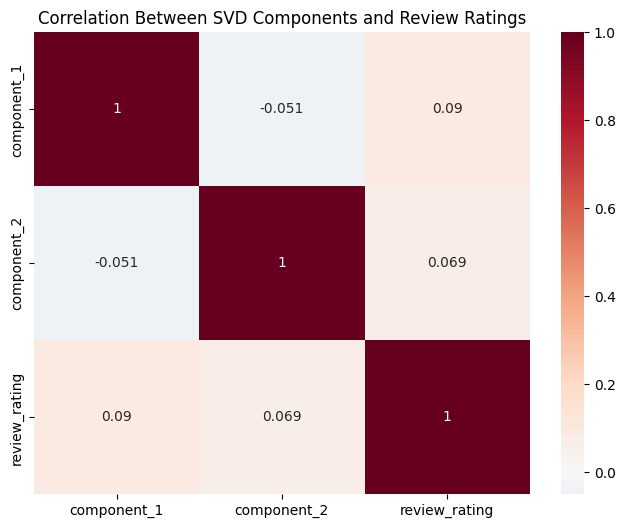

In [17]:
# Step 5: Correlation between SVD Components and Ratings
df_svd = pd.DataFrame(reduced_tfidf, columns=['component_1', 'component_2'])
df_svd['review_rating'] = ratings

# Correlation heatmap
correlation_matrix = df_svd.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0)
plt.title("Correlation Between SVD Components and Review Ratings")
plt.show()

## 4. **Sentiment Analysis:**
   - **Why:** Sentiment polarity (positive, negative) and intensity can be directly related to the ratings. A strongly positive review is likely to have a higher rating, and vice versa.
   - **How:** Apply a sentiment analysis model (e.g., VADER, TextBlob, or even a custom sentiment model) to extract sentiment scores. These scores can be used as additional features alongside TF-IDF or embeddings.

In [18]:
## Bar chart or pie chart showing the distribution of positive, neutral, and negative sentiments in reviews.

# Define a function to classify sentiment
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

# Apply sentiment analysis
df['sentiment'] = df['review_text_translated'].apply(lambda x: get_sentiment(x) if pd.notnull(x) else 'Neutral')

# Sentiment Distribution
sentiment_dist = df['sentiment'].value_counts()

# Calculate percentages
total_reviews = sentiment_dist.sum()
sentiment_percentages = (sentiment_dist / total_reviews) * 100

# Convert the sentiment_percentages series to a DataFrame
sentiment_percentages_df = sentiment_percentages.reset_index()
sentiment_percentages_df.columns = ['Sentiment', 'Percentage']

# Define colors for the sentiment categories
colors = {'Positive': '#2ca02c', 'Neutral': '#1f77b4', 'Negative': '#d62728'}

# Create a bar chart with Plotly
fig_bar = go.Figure()

fig_bar.add_trace(go.Bar(
    x=sentiment_dist.index,
    y=sentiment_dist.values,
    marker_color=[colors[sentiment] for sentiment in sentiment_dist.index],
    name='Sentiment'
))

fig_bar.update_layout(
    title_x=0.5,
    xaxis_title='Sentiment',
    yaxis_title='Frequency',
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="#000000"
    ),
    xaxis_tickangle=0
)

# Save the figure as a static image with transparent background
pio.write_image(fig_bar, '../plots/3_3_plot.png', scale=2, format='png', engine='kaleido')

# Define the HTML template to display the image and the table side by side
html_template = '''
<div style="display: flex; align-items: center;">
    <div style="flex: 1;">
        <img src="{img_path}" width="{img_width}" height="{img_height}">
    </div>
    <div style="flex: 1; padding-left: 20px;">
        {table}
    </div>
</div>
'''

# Generate the HTML content
html_content = html_template.format(
    img_path='../plots/3_3_plot.png',
    img_width=800,  
    img_height=400,
    table=sentiment_percentages_df.to_html(index=False)
)

# Display the content
display(HTML(html_content))

Sentiment,Percentage
Positive,80.076728
Neutral,11.132063
Negative,8.791209


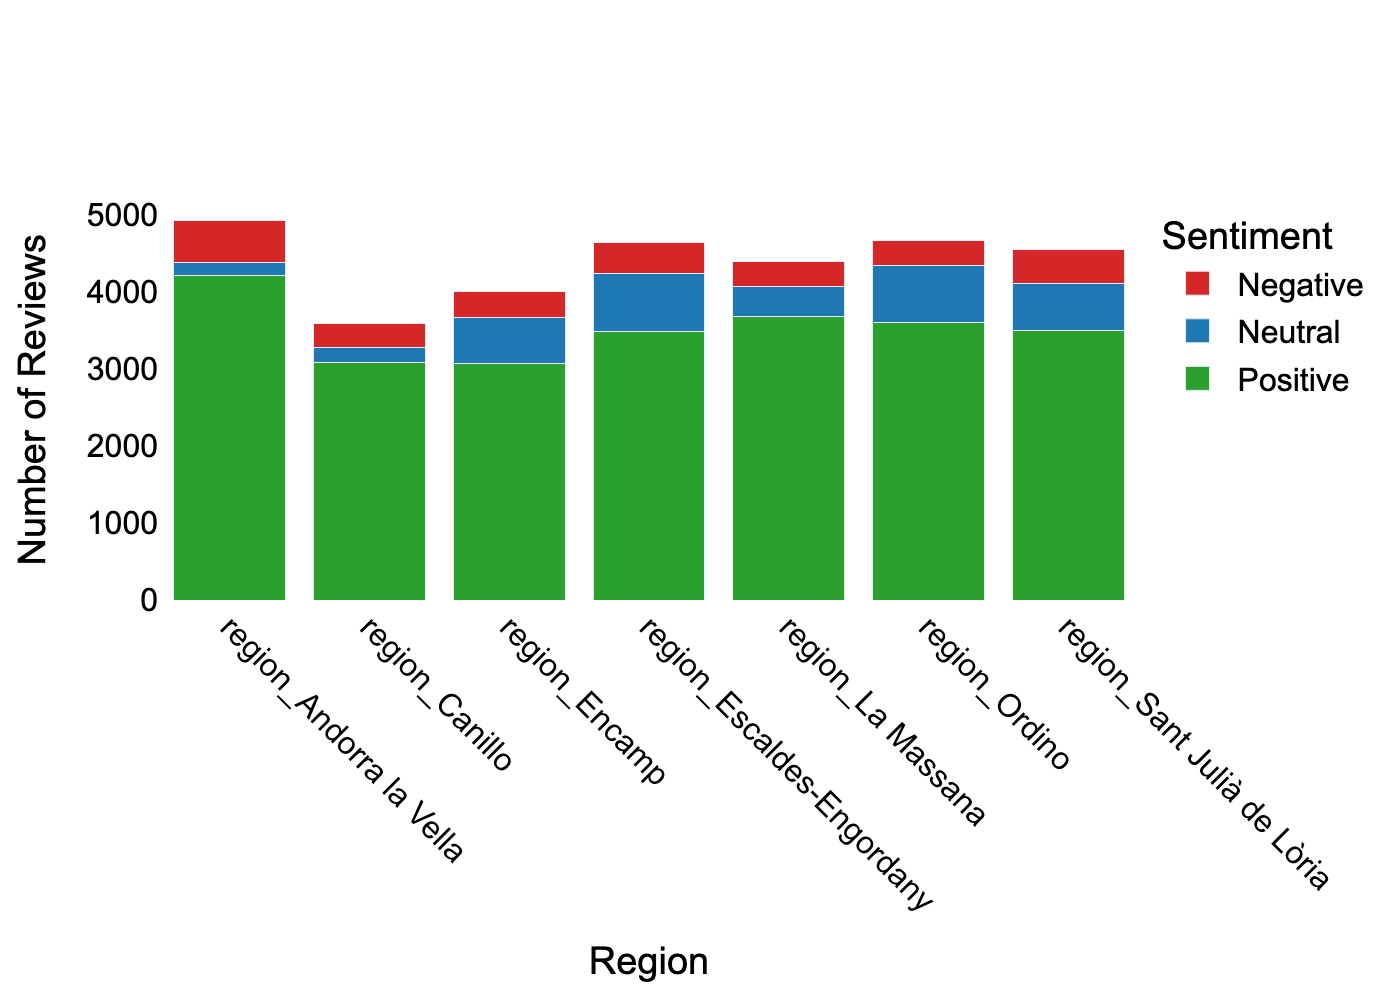

In [19]:
# List of one-hot encoded region columns
region_columns = [col for col in df.columns if col.startswith('region_')]

# Define a function to classify sentiment
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

# Apply sentiment analysis
df['sentiment'] = df['review_text_translated'].apply(lambda x: get_sentiment(x) if pd.notnull(x) else 'Neutral')

# Initialize a DataFrame to store the sentiment counts by region
sentiment_region_counts = pd.DataFrame()

# Calculate sentiment counts for each region
for region in region_columns:
    # Calculate the counts for each sentiment within this region
    region_df = df[df[region] == 1]  # Filter reviews for the current region
    sentiment_counts = region_df['sentiment'].value_counts().reindex(['Positive', 'Neutral', 'Negative']).fillna(0)

    # Store the counts in the sentiment_region_counts DataFrame
    sentiment_region_counts[region] = sentiment_counts

# Transpose the DataFrame to match the required format
sentiment_region_counts = sentiment_region_counts.T

# Create a stacked bar chart with Plotly
fig_bar = go.Figure()

sentiments = ['Positive', 'Neutral', 'Negative']
colors = {'Positive': '#2ca02c', 'Neutral': '#1f77b4', 'Negative': '#d62728'}

for sentiment in sentiments:
    fig_bar.add_trace(go.Bar(
        x=sentiment_region_counts.index,
        y=sentiment_region_counts[sentiment],
        name=sentiment,
        marker_color=colors[sentiment]
    ))

# Customize layout
fig_bar.update_layout(
    barmode='stack',
    title_x=0.5,
    xaxis_title='Region',
    yaxis_title='Number of Reviews',
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(
        family="Arial, sans-serif",
        size=16,
        color="#000000"
    ),
    xaxis_tickangle=45,
    legend_title_text='Sentiment'
)

# Save the figure as a static image with transparent background
pio.write_image(fig_bar, '../plots/4_2_plot_updated.png', scale=2, format='png', engine='kaleido')

# Optionally, display the static image
display(Image(filename='../plots/4_2_plot_updated.png', width=800, height=600))

## 5. **Text Length and Readability Scores:**
   - **Why:** The length of the review and its readability might correlate with the detail and thoroughness of the review, which in turn might influence the rating.
   - **How:** Compute features such as the number of words, sentences, and Flesch-Kincaid readability scores for each review. These features can be useful in combination with text-based features.

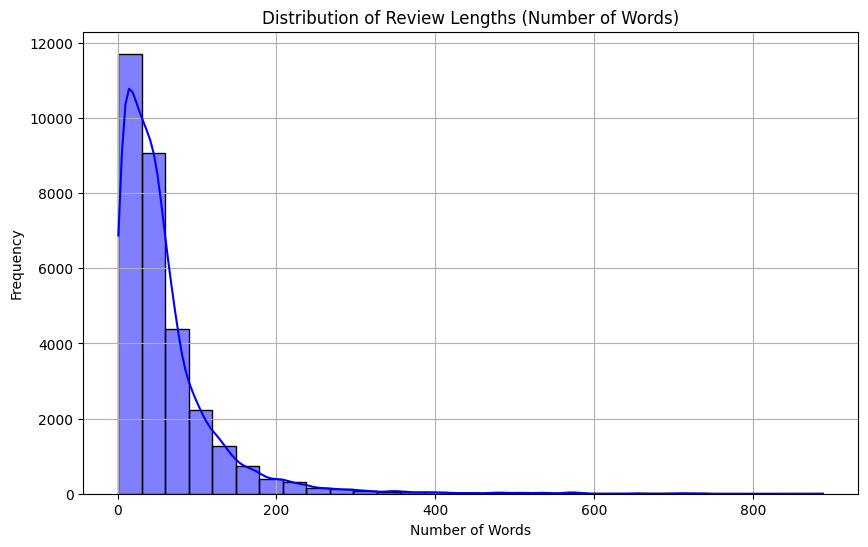

In [20]:
# Function to calculate text length and readability scores
def calculate_text_stats(text):
    num_words = len(text.split())
    num_characters = len(text)
    num_sentences = textstat.sentence_count(text)
    flesch_reading_ease = textstat.flesch_reading_ease(text)
    flesch_kincaid_grade = textstat.flesch_kincaid_grade(text)
    
    return num_words, num_characters, num_sentences, flesch_reading_ease, flesch_kincaid_grade

# Apply the function to each review
df[['num_words', 'num_characters', 'num_sentences', 'flesch_reading_ease', 'flesch_kincaid_grade']] = df['review_text_translated'].apply(
    lambda x: calculate_text_stats(x) if pd.notnull(x) else (0, 0, 0, 0, 0)
).apply(pd.Series)

# Plot 1: Distribution of Review Lengths (Number of Words)
plt.figure(figsize=(10, 6))
sns.histplot(df['num_words'], bins=30, kde=True, color='blue')
plt.title('Distribution of Review Lengths (Number of Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

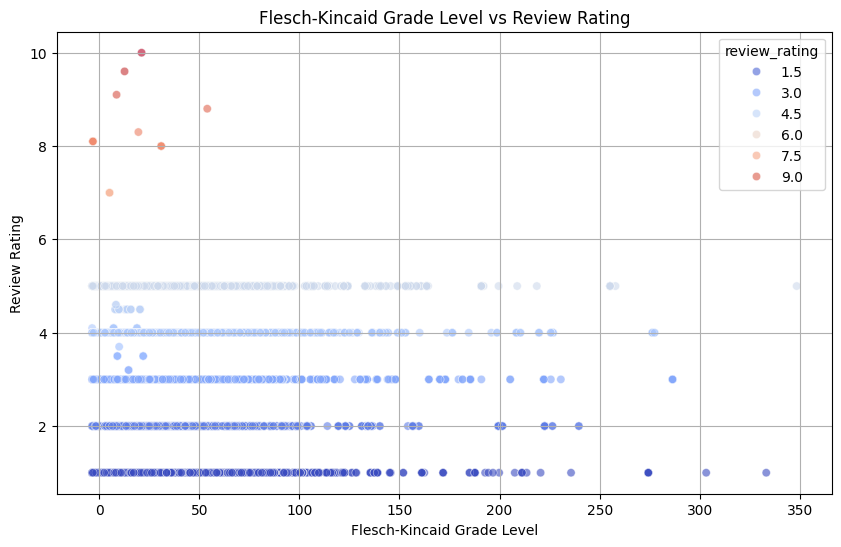

In [21]:
# Plot 2: Scatter plot of Flesch-Kincaid Grade Level vs Review Rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='flesch_kincaid_grade', y='review_rating', data=df, hue='review_rating', palette='coolwarm', alpha=0.6)
plt.title('Flesch-Kincaid Grade Level vs Review Rating')
plt.xlabel('Flesch-Kincaid Grade Level')
plt.ylabel('Review Rating')
plt.grid(True)
plt.show()

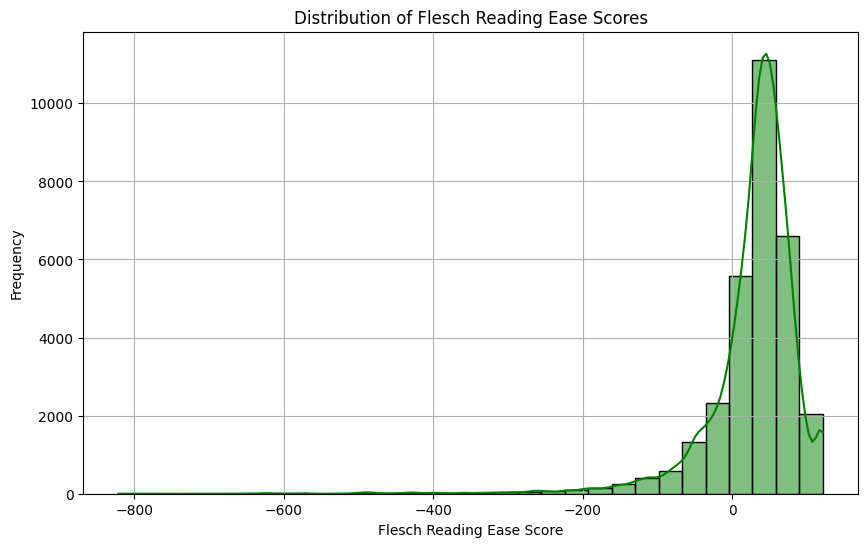

In [22]:
# Plot 3: Flesch Reading Ease Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['flesch_reading_ease'], bins=30, kde=True, color='green')
plt.title('Distribution of Flesch Reading Ease Scores')
plt.xlabel('Flesch Reading Ease Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## 6. **Topic Modeling (LDA - Latent Dirichlet Allocation):**
   - **Why:** LDA can uncover hidden topics within reviews, which might correlate with different ratings. For example, reviews discussing "cleanliness" might have different ratings than those discussing "location."
   - **How:** Use LDA to assign topic probabilities to each review. These topic distributions can serve as features, helping the model understand which aspects of a review contribute to the rating.

In [23]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenize and lowercasing
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum()]  # Lemmatization and removing non-alphanumeric tokens
    tokens = [word for word in tokens if word not in stop_words]  # Removing stopwords
    return tokens

# Apply preprocessing to the review text
df['processed_review'] = df['review_text_translated'].apply(preprocess_text)

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(df['processed_review'])
corpus = [dictionary.doc2bow(text) for text in df['processed_review']]

# Train LDA model
num_topics = 5  # You can experiment with different numbers of topics
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)

# Display the topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx}\nWords: {topic}\n")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/normagutierrez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/normagutierrez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/normagutierrez/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Topic: 0
Words: 0.027*"de" + 0.024*"htel" + 0.024*"le" + 0.018*"trs" + 0.015*"et" + 0.014*"la" + 0.013*"lhtel" + 0.009*"est" + 0.008*"pour" + 0.008*"un"

Topic: 1
Words: 0.039*"good" + 0.037*"hotel" + 0.023*"room" + 0.019*"staff" + 0.017*"clean" + 0.016*"well" + 0.016*"breakfast" + 0.015*"great" + 0.014*"friendly" + 0.013*"location"

Topic: 2
Words: 0.018*"room" + 0.017*"wa" + 0.016*"hotel" + 0.013*"u" + 0.007*"parking" + 0.007*"day" + 0.007*"night" + 0.006*"bed" + 0.006*"ha" + 0.006*"without"

Topic: 3
Words: 0.047*"la" + 0.041*"de" + 0.032*"que" + 0.030*"el" + 0.022*"muy" + 0.021*"en" + 0.015*"e" + 0.015*"un" + 0.013*"hotel" + 0.013*"con"

Topic: 4
Words: 0.041*"wa" + 0.024*"hotel" + 0.023*"room" + 0.010*"staff" + 0.009*"good" + 0.009*"breakfast" + 0.008*"nice" + 0.007*"great" + 0.006*"stay" + 0.006*"would"



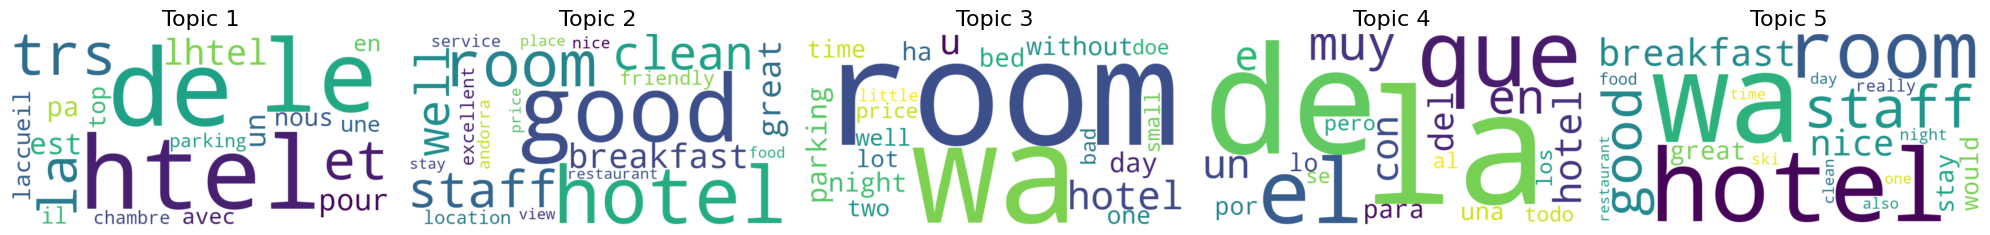

In [24]:
# Assign topics to each review
df['lda_topics'] = [lda_model.get_document_topics(bow) for bow in corpus]

# Topic distribution visualization (Word Clouds)
fig, axes = plt.subplots(1, num_topics, figsize=(20, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    topic_words = dict(lda_model.show_topic(i, 20))  # Top 20 words for each topic
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'Topic {i+1}', fontsize=16)

plt.tight_layout()
plt.show()

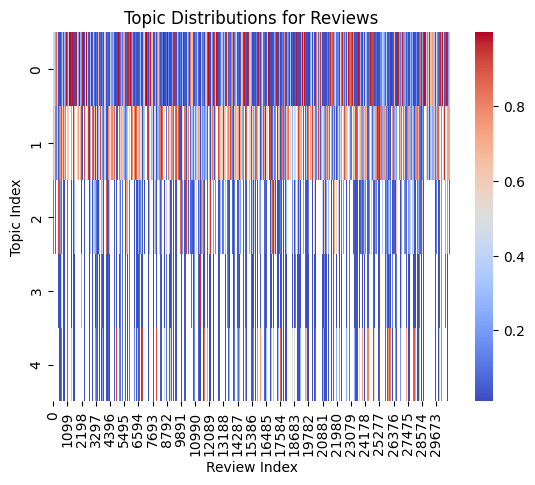

In [25]:
# Topic distribution for each review (optional visualization as a heatmap)
import seaborn as sns
topic_distributions = pd.DataFrame(df['lda_topics'].apply(lambda x: [prob for _, prob in x]).tolist())
sns.heatmap(topic_distributions.T, cmap='coolwarm')
plt.title('Topic Distributions for Reviews')
plt.xlabel('Review Index')
plt.ylabel('Topic Index')
plt.show()